In [2]:
from skimage.morphology import binary_dilation
from tqdm.auto import tqdm
from skimage.measure import regionprops_table
from skimage.transform import rotate
from skimage.measure import label
from joblib import Parallel, delayed
from skimage.segmentation import clear_border 
import tifffile
import numpy as np
import matplotlib.pyplot as plt

def crop_single_cell(single_cell, img_to_crop):
    true_y, true_x = np.where(single_cell)
    
    # Determine the bounding box coordinates
    min_x, max_x = true_x.min(), true_x.max()
    min_y, max_y = true_y.min(), true_y.max()
    
    # Crop the array to the bounding box around the mask
    cropped_single_cell = img_to_crop[min_y:max_y+1, min_x:max_x+1]
    return np.pad(cropped_single_cell, 1)

In [3]:
def get_single_cell_labels(mask):
    single_cell_labels = []
    mask = clear_border(mask)
    mask_labels = np.unique(mask)[1:]
    for mask_label in (mask_labels):
        dilated_mask = binary_dilation(mask == mask_label)
        if len(np.unique(dilated_mask * mask)) == 2:
            single_cell_labels.append(mask_label)
        else:
            #group_cell_sizes.append(
            #    np.sum(mask == mask_label)
            #)
            pass
    return single_cell_labels
    


In [46]:
def get_single_cell_widths(mask):
    single_cell_labels = get_single_cell_labels(mask)

    widths = []
    for mask_label in (single_cell_labels):
        cropped_single_cell = crop_single_cell(mask ==  mask_label, mask ==  mask_label) > 0
        if cropped_single_cell.sum() > 25:
            regionprops = regionprops_table(label(cropped_single_cell), properties = ["orientation"])
            cell_angle = regionprops["orientation"][0]
            rotation_widths = []
            for rotation_angle in range(361):
                rotated_cell = rotate(cropped_single_cell, rotation_angle, resize=True, order = 0)
                width = rotated_cell[rotated_cell.shape[0]//2-3:rotated_cell.shape[0]//2+3].mean(axis=0).sum()
                rotation_widths.append(width)
            widths.append(np.min(rotation_widths))
    return widths

In [35]:
def get_all_cell_widths(mask):
    cell_labels = np.unique(mask)[1:]

    cell_data = []
    
    for mask_label in (cell_labels):
        cropped_single_cell = crop_single_cell(mask ==  mask_label, mask ==  mask_label) > 0
        if cropped_single_cell.sum() > 25:
            regionprops = regionprops_table(label(cropped_single_cell), properties = ["orientation"])
            cell_angle = regionprops["orientation"][0]
            rotation_widths = []
            for rotation_angle in range(361):
                rotated_cell = rotate(cropped_single_cell, rotation_angle, resize=True, order = 0)
                width = rotated_cell[rotated_cell.shape[0]//2-3:rotated_cell.shape[0]//2+3].mean(axis=0).sum()
                rotation_widths.append(width)
            width = np.min(rotation_widths)
            cell_data.append([width, mask_label])
        
    return cell_data

In [36]:
pix_mic_conv = 0.11

In [49]:
def get_single_cell_widths_mask_stack(masks):
    widths = zip(*Parallel(n_jobs=-1)(delayed(get_single_cell_widths)(mask) for mask in masks))
    widths = [x for width in widths for x in width]
    widths = np.array(widths)*pix_mic_conv
    return widths
#widths_symbac = widths_symbac[np.argwhere((widths_symbac < 1.7) & (widths_symbac > 0.7))]

In [38]:
def get_all_cell_widths_mask_stack(masks):
    cell_data = Parallel(n_jobs=-1)(delayed(get_all_cell_widths)(mask) for mask in masks)
    return cell_data


In [39]:
FL_image = tifffile.imread("to_segment/FL-3.tif")

In [40]:
masks_symbac = tifffile.imread("segmented/symbac_seg.tif")
masks_omnipose = tifffile.imread("segmented/bact_fluor_omni.tif")


In [41]:
cell_data_symbac = get_all_cell_widths_mask_stack(masks_symbac)
cell_data_omnipose = get_all_cell_widths_mask_stack(masks_omnipose)

In [43]:
import pandas as pd

In [80]:
all_widths_omni = list(pd.concat([pd.DataFrame(x)[0]*0.11 for x in cell_data_omnipose]))
all_widths_symbac = list(pd.concat([pd.DataFrame(x)[0]*0.11 for x in cell_data_symbac]))

In [50]:
widths_symbac = get_single_cell_widths_mask_stack(masks_symbac)
widths_omnipose = get_single_cell_widths_mask_stack(masks_omnipose)


In [51]:
widths_symbac_cropped = widths_symbac[np.argwhere((widths_symbac < 1.7) & (widths_symbac > 0.7))]
widths_omnipose_cropped = widths_omnipose[np.argwhere((widths_omnipose < 1.7) & (widths_omnipose > 0.8))]


In [52]:
widths_symbac_cropped_df = pd.DataFrame(widths_symbac_cropped)
widths_symbac_cropped_df.columns = ["Width"]
widths_symbac_cropped_df["Cell type"] = "Alone Cell"
widths_symbac_cropped_df["Model"] = "SyMBac trained"

widths_omnipose_cropped_df = pd.DataFrame(widths_omnipose_cropped)
widths_omnipose_cropped_df.columns = ["Width"]
widths_omnipose_cropped_df["Cell type"] = "Alone Cell"
widths_omnipose_cropped_df["Model"] = "Pretrained"

all_widths_symbac_df = pd.DataFrame(all_widths_symbac)
all_widths_symbac_df.columns = ["Width"]
all_widths_symbac_df["Cell type"] = "Colony Cell"
all_widths_symbac_df["Model"] = "SyMBac trained"

all_widths_omni_df = pd.DataFrame(all_widths_omni)
all_widths_omni_df.columns = ["Width"]
all_widths_omni_df["Cell type"] = "Colony Cell"
all_widths_omni_df["Model"] = "Pretrained"

all_data_omni_symbac_df = pd.concat([widths_symbac_cropped_df, widths_omnipose_cropped_df, all_widths_symbac_df, all_widths_omni_df])
all_data_omni_symbac_df.to_pickle("all_data_omni_symbac_df.pickle")

In [98]:
np.std(widths_symbac_cropped) / np.mean(widths_symbac_cropped)

0.06505030780492813

In [100]:
all_data_omni_symbac_df.groupby(["Cell type", "Model"]).mean()

Width
Cell type   Model                   
Alone Cell  Pretrained      1.213929
            SyMBac trained  0.940596
Colony Cell Pretrained      1.003883
            SyMBac trained  0.889085

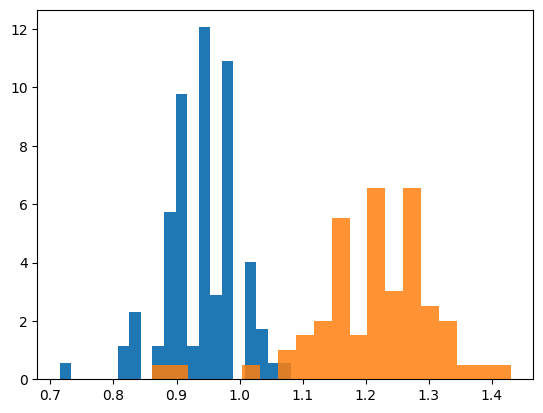

In [53]:
plt.hist(widths_symbac_cropped, bins = 20, density = True)
plt.hist(widths_omnipose_cropped, bins = 20, alpha = 0.85, density = True)

plt.show()

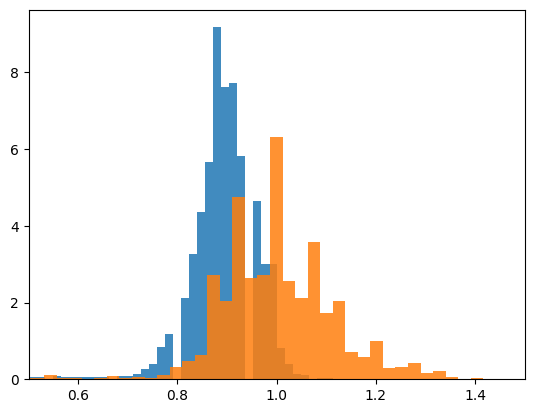

In [54]:
plt.hist(all_widths_symbac, bins = 100, alpha = 0.85, density = True)
plt.hist(all_widths_omni, bins = 200, alpha = 0.85, density = True)
plt.xlim(0.5,1.5)

plt.show()

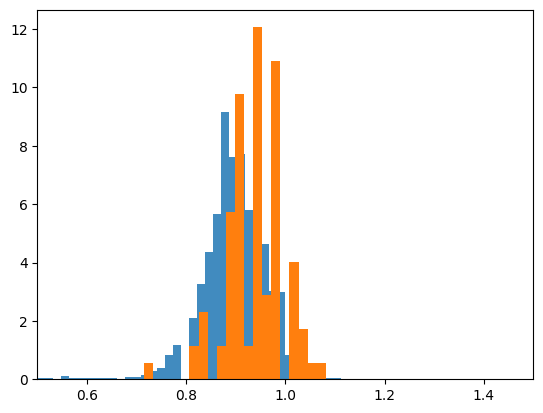

In [55]:
plt.hist(all_widths_symbac, bins = 100, alpha = 0.85, density = True)
plt.hist(widths_symbac_cropped, bins = 20, density = True)
plt.xlim(0.5,1.5)
plt.show()

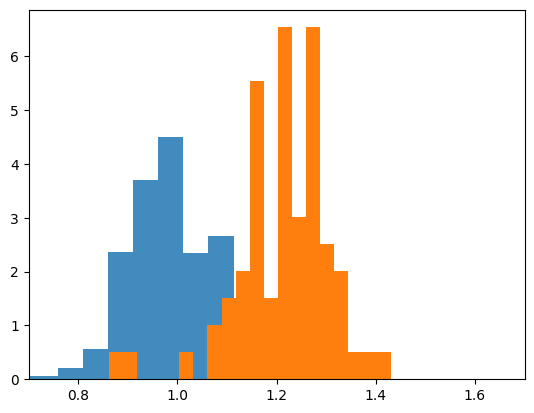

In [56]:
plt.hist(all_widths_omni, bins = 100, alpha = 0.85, density = True)
plt.hist(widths_omnipose_cropped, bins = 20, density = True)
plt.xlim(0.7,1.7)
plt.show()

In [57]:
import pandas as pd

In [65]:
def get_width_mask_image(mask, cell_data):
    size_masks = np.zeros_like(mask).astype(float)
    for width, mask_label in cell_data:
        bin_mask = (mask == mask_label)
        size_masks += (bin_mask*width)
    return size_masks

In [91]:
symbac_mask_width_data = pd.DataFrame()
for i, stack in enumerate(cell_data_symbac):
    _ = pd.DataFrame(stack)
    _.columns = ["Width", "label"]
    _["stack"] = i
    
    symbac_mask_width_data = pd.concat([symbac_mask_width_data, _])
symbac_mask_width_data.reset_index(inplace=True, drop=True)
symbac_mask_width_data.to_pickle("symbac_mask_width_data.pickle")

In [89]:
ommnipose_mask_width_data = pd.DataFrame()
for i, stack in enumerate(cell_data_omnipose):
    _ = pd.DataFrame(stack)
    _.columns = ["Width", "label"]
    _["stack"] = i
    
    ommnipose_mask_width_data = pd.concat([ommnipose_mask_width_data, _])
ommnipose_mask_width_data.reset_index(inplace=True, drop=True)
ommnipose_mask_width_data.to_pickle("ommnipose_mask_width_data.pickle")

In [ ]:
size_masks_omni = get_width_mask_image(masks_omnipose[0], cell_data_omnipose[0])
plt.figure(figsize=(10,10))
plt.imshow(size_masks_omni[300:900,300:900] * 0.11, vmin = 5.426 * 0.11, vmax = 11.66 * 0.11, cmap = "turbo", interpolation="none")
clb = plt.colorbar()
clb.ax.set_title('Width ($\mu m$)')
plt.axis("off")
plt.title("Pretrained segmentation")

Text(0.5, 1.0, 'Pretrained segmentation')

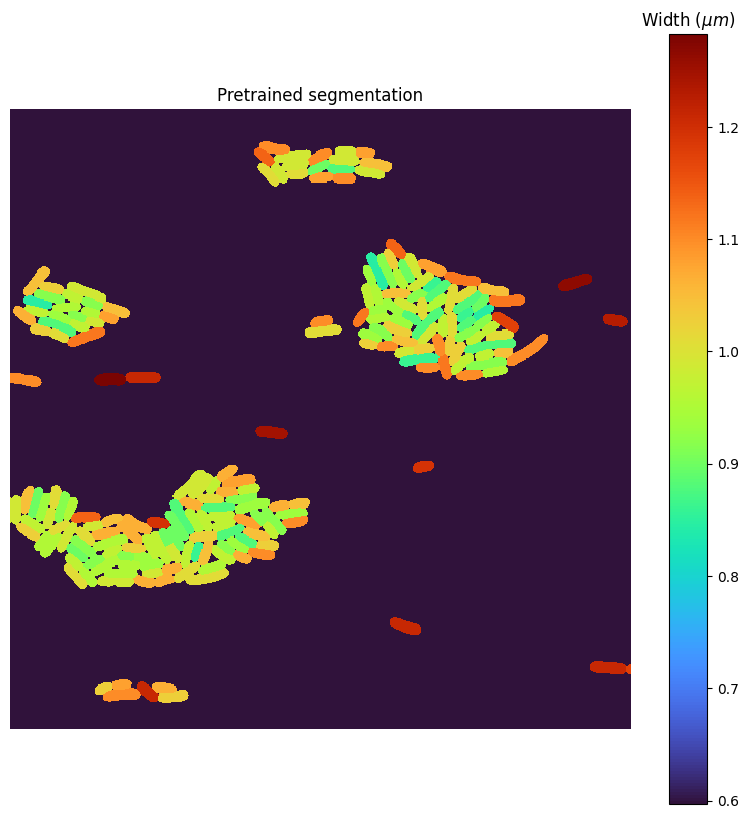

In [69]:
size_masks_omni = get_width_mask_image(masks_omnipose[0], cell_data_omnipose[0])
plt.figure(figsize=(10,10))
plt.imshow(size_masks_omni[300:900,300:900] * 0.11, vmin = 5.426 * 0.11, vmax = 11.66 * 0.11, cmap = "turbo", interpolation="none")
clb = plt.colorbar()
clb.ax.set_title('Width ($\mu m$)')
plt.axis("off")
plt.title("Pretrained segmentation")

Text(0.5, 1.0, 'SyMBac trained segmentation')

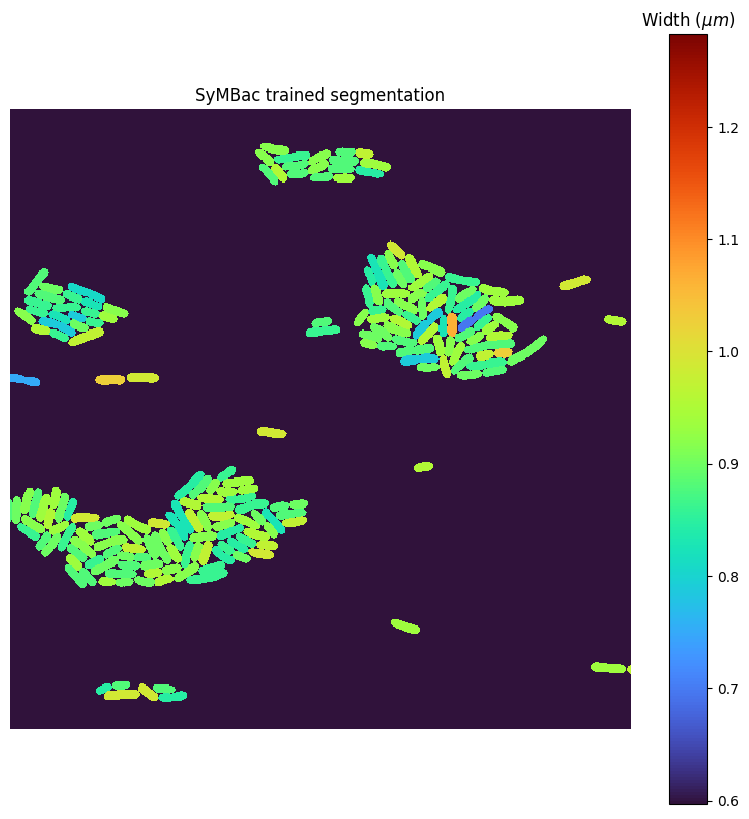

In [70]:
size_masks_symbac = get_width_mask_image(masks_symbac[0], cell_data_symbac[0])
plt.figure(figsize=(10,10))
plt.imshow(size_masks_symbac[300:900,300:900] * 0.11, vmin = 5.426 * 0.11, vmax = 11.66 * 0.11, cmap = "turbo", interpolation="none")
clb = plt.colorbar()
clb.ax.set_title('Width ($\mu m$)')
plt.axis("off")
plt.title("SyMBac trained segmentation")

In [272]:
ss_labels = get_single_cell_labels(masks_symbac[0])

neighbour_threshold = 5
high_neighbour_cell_labels = []
mask = masks_symbac[0]
mask = clear_border(mask)
mask_labels = np.unique(mask)[1:]
for mask_label in (mask_labels):
    single_cell_mask = (mask == mask_label)
    if np.sum(single_cell_mask) > 25:
        dilated_mask = binary_dilation(single_cell_mask)
        if len(np.unique(dilated_mask * mask)) >= neighbour_threshold:
            high_neighbour_cell_labels.append(mask_label)
        else:
            pass

In [273]:
cell_labels = np.unique(masks_symbac[0])[1:]

In [274]:
ss_widths = []
other_widths = []
high_neighbour_widths = []
for cell_label in cell_labels:
    width = ((masks_symbac[0] == cell_label) * size_masks_symbac).max()
    if cell_label in ss_labels:
        ss_widths.append(width)
    elif cell_label in high_neighbour_cell_labels:
        high_neighbour_widths.append(width)
    else:
        other_widths.append(width)
other_widths = np.array(other_widths)

In [275]:
np.mean(ss_widths) * 0.11

0.9469871794871796

In [277]:
np.mean(high_neighbour_widths) * 0.11

0.896371237458194

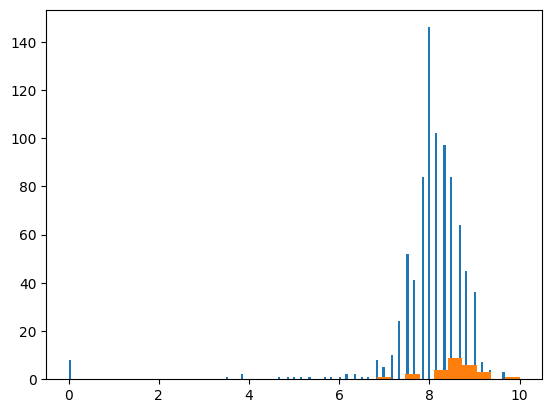

In [222]:
plt.hist(other_widths, bins = 200)
plt.hist(ss_widths)
plt.show()

In [251]:
ss_labels = get_single_cell_labels(masks_omnipose[0])

neighbour_threshold = 5
high_neighbour_cell_labels = []
mask = masks_omnipose[0]
mask = clear_border(mask)
mask_labels = np.unique(mask)[1:]
for mask_label in (mask_labels):
    single_cell_mask = (mask == mask_label)
    if np.sum(single_cell_mask) > 25:
        dilated_mask = binary_dilation(single_cell_mask)
        if len(np.unique(dilated_mask * mask)) >= neighbour_threshold:
            high_neighbour_cell_labels.append(mask_label)
        else:
            pass

In [252]:
cell_labels = np.unique(masks_omnipose[0])[1:]

In [253]:
ss_widths = []
other_widths = []
high_neighbour_widths = []
for cell_label in cell_labels:
    width = ((masks_omnipose[0] == cell_label) * size_masks_omni).max()
    if cell_label in ss_labels:
        ss_widths.append(width)
    elif cell_label in high_neighbour_cell_labels:
        high_neighbour_widths.append(width)
    else:
        other_widths.append(width)
other_widths = np.array(other_widths)

In [254]:
np.mean(ss_widths) * 0.11

0.9313333333333333

In [257]:
np.mean(high_neighbour_widths) * 0.11

0.9219901234567901

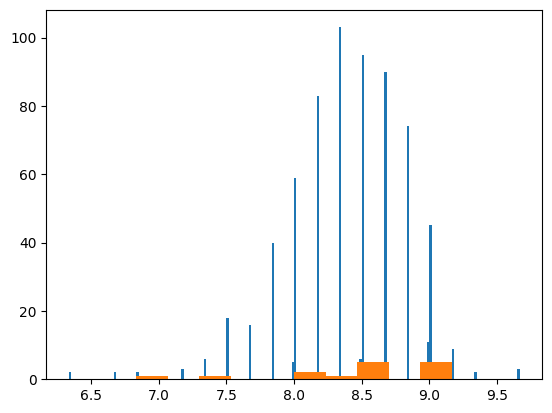

In [258]:
plt.hist(high_neighbour_widths, bins = 200)
plt.hist(ss_widths)
plt.show()

[20,
 22,
 24,
 25,
 27,
 31,
 32,
 33,
 35,
 36,
 37,
 38,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 48,
 49,
 50,
 52,
 53,
 54,
 55,
 56,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 70,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 101,
 102,
 103,
 104,
 105,
 106,
 109,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 147,
 149,
 151,
 152,
 153,
 154,
 155,
 157,
 158,
 159,
 160,
 161,
 162,
 164,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 180,
 181,
 182,
 183,
 184,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 233,
 234,
 235,
 239,
 240,
 241,
 24